taken from https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization

I modified because I think there are some conceptual errors!

In [76]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [112]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# If you want to use Theano, all you need to change
# is the dim ordering whenever you are dealing with
# the image array. Instead of
# (samples, rows, cols, channels) it should be
# (samples, channels, rows, cols)

# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = './all'
np.random.seed(2016)
split_random_state = 7
split = .9


def load_numeric_training(standardize=False):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(scaler, standardize=False):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=128, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        ret_val = np.around(X / 255.0)
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return ret_val


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...
Training data loaded!


In [113]:
n_cats = len(np.unique(y_tr))

In [114]:
X_num_tr.shape

(891, 192)

In [115]:
X_num_tr

array([[0.017578, 0.003906, 0.058594, ..., 0.020508, 0.      , 0.023438],
       [0.025391, 0.082031, 0.029297, ..., 0.24219 , 0.003906, 0.      ],
       [0.023438, 0.037109, 0.056641, ..., 0.      , 0.      , 0.009766],
       ...,
       [0.017578, 0.021484, 0.046875, ..., 0.004883, 0.014648, 0.044922],
       [0.003906, 0.007812, 0.023438, ..., 0.015625, 0.012695, 0.039062],
       [0.060547, 0.0625  , 0.013672, ..., 0.000977, 0.      , 0.006836]])

# Train using only features

In [5]:
import keras
from keras import Sequential
from keras import Model
from keras.layers import ReLU, Dense, Conv2D, Softmax, Conv1D, Flatten, Dropout, Input,GlobalMaxPooling2D,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
model = Sequential()
model.add(Dense(64, input_shape = (192,), activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'relu'))
#model.add(Dense(128,activation = 'relu'))
model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))
from keras.callbacks import ReduceLROnPlateau
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                        patience=5, verbose=1, mode='auto', 
                        min_delta=0.01,  min_lr=0)
erl = EarlyStopping(monitor='val_loss',
                        patience=10, verbose=1, mode='auto', 
                        min_delta=0.01)

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
out_layer (Dense)            (None, 99)                12771     
Total params: 33,443
Trainable params: 33,443
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(X_num_tr, y_tr_cat, batch_size = 10, epochs = 100, validation_data=(X_num_val, y_val_cat), callbacks=[rlr, erl])

Train on 891 samples, validate on 99 samples
Epoch 1/100
891/891 [==============================] - 1s 2ms/step - loss: 4.5855 - acc: 0.0314 - val_loss: 4.5475 - val_acc: 0.1010
Epoch 2/100
891/891 [==============================] - 0s 283us/step - loss: 4.4629 - acc: 0.0797 - val_loss: 4.2523 - val_acc: 0.1616
Epoch 3/100
891/891 [==============================] - 0s 286us/step - loss: 3.9583 - acc: 0.1336 - val_loss: 3.4712 - val_acc: 0.2121
Epoch 4/100
891/891 [==============================] - 0s 283us/step - loss: 3.2452 - acc: 0.2110 - val_loss: 2.8098 - val_acc: 0.3939
Epoch 5/100
891/891 [==============================] - 0s 286us/step - loss: 2.7632 - acc: 0.2974 - val_loss: 2.4148 - val_acc: 0.4646
Epoch 6/100
891/891 [==============================] - 0s 285us/step - loss: 2.4448 - acc: 0.3479 - val_loss: 2.1233 - val_acc: 0.4747
Epoch 7/100
891/891 [==============================] - 0s 284us/step - loss: 2.1869 - acc: 0.4074 - val_loss: 1.8807 - val_acc: 0.4949
Epoch 8/100


891/891 [==============================] - 0s 282us/step - loss: 0.2637 - acc: 0.9226 - val_loss: 0.3143 - val_acc: 0.8889
Epoch 61/100
891/891 [==============================] - 0s 286us/step - loss: 0.2529 - acc: 0.9327 - val_loss: 0.2728 - val_acc: 0.9091
Epoch 62/100
891/891 [==============================] - 0s 284us/step - loss: 0.2489 - acc: 0.9327 - val_loss: 0.2756 - val_acc: 0.8990
Epoch 63/100
891/891 [==============================] - 0s 285us/step - loss: 0.2704 - acc: 0.9214 - val_loss: 0.2913 - val_acc: 0.9192
Epoch 64/100
891/891 [==============================] - 0s 281us/step - loss: 0.2790 - acc: 0.9113 - val_loss: 0.2961 - val_acc: 0.9091
Epoch 65/100
891/891 [==============================] - 0s 281us/step - loss: 0.2373 - acc: 0.9338 - val_loss: 0.2584 - val_acc: 0.9293
Epoch 66/100
891/891 [==============================] - 0s 284us/step - loss: 0.2313 - acc: 0.9383 - val_loss: 0.2996 - val_acc: 0.8687
Epoch 67/100
891/891 [==============================] - 0s 28

## Train using images

In [43]:
X_img_tr.shape

(891, 96, 96, 1)

### custom generator

usar esto para el custom generator

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32,  shuffle=True):
        'Initialization'
        self.n_vals = len(targets)
        self.ids = np.arange(self.n_vals)
        self.batch_size = batch_size
        self.images = images
        self.targets = targets

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [97]:
class custom_generator(object):
    def __init__(self, images, targets, batch_size = 26):
        self.n_vals = len(targets)
        self.ids = np.arange(self.n_vals)
        self.batch_size = batch_size
        self.images = images
        self.targets = targets
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def generate(self):        
        rand_choices = np.random.choice(self.ids, size = self.batch_size)
        images = self.images[rand_choices]
        y_cat = self.targets[rand_choices]
        return images, y_cat
    
    

In [98]:
X_img_tr[[0,25]].shape

(2, 96, 96, 1)

In [99]:
generator = custom_generator(X_img_tr, y_tr_cat)

<IPython.core.display.Javascript object>


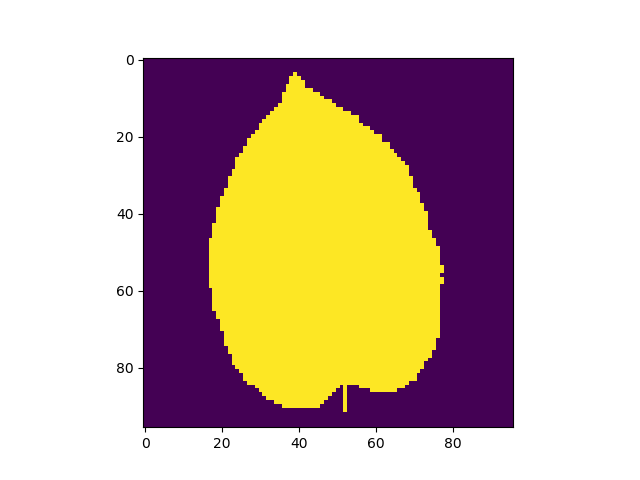

In [111]:
batch_train_x, batch_train_y = generator.generate()
plt.figure()
plt.imshow(batch_train_x[0][:,:,0])

In [26]:
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# A little hacky piece of code to get access to the indices of the images
# the data augmenter is working with.
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, X, y=None, batch_size=26, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator2(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    def next(self):
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            # We changed index_array to self.index_array
            self.index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        for i, j in enumerate(self.index_array):
            x = self.X[j]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[self.index_array]
        return batch_x, batch_y

print('Creating Data Augmenter...')
imgen = ImageDataGenerator2(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=np.random.randint(1, 10000))
print('Finished making data augmenter...')

Creating Data Augmenter...
Finished making data augmenter...


In [30]:
imgen_train[-2][1].shape

(26, 99)

In [46]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, Concatenate

In [34]:
next(imgen_train)

ValueError: too many values to unpack (expected 3)

In [49]:



def combined_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(8, 5, 5, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = Concatenate()([x, numerical])

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(input=[image, numerical], output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = combined_model()
print('Model created!')

Creating the model...
Model created!


/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(96, 96, 1..., padding="same")`
  if __name__ == '__main__':
/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
  
/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 96, 96, 8)    208         image[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 96, 96, 8)    0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 48, 48, 8)    0           activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_8 (

In [31]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y

# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit_generator(combined_generator(imgen_train, X_num_tr),
                              samples_per_epoch=X_num_tr.shape[0],
                              nb_epoch=89,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              nb_val_samples=X_num_val.shape[0],
                              verbose=0,
                              callbacks=[best_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...


/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=([array([[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=891, epochs=89, validation_steps=99)`


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
    ...

In [51]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y

# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit_generator(combined_generator(imgen_train, X_num_tr),
                              samples_per_epoch=X_num_tr.shape[0],
                              nb_epoch=89,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              nb_val_samples=X_num_val.shape[0],
                              verbose=0,
                              callbacks=[best_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...


/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ivan/coding_projects/testing3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=([array([[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=891, epochs=89, validation_steps=99)`


ValueError: too many values to unpack (expected 3)

In [23]:
id_vec['id']

0         1
1         2
2         3
3         5
4         6
5         8
6        10
7        11
8        14
9        15
10       17
11       18
12       20
13       21
14       22
15       25
16       26
17       27
18       29
19       30
20       31
21       32
22       34
23       35
24       37
25       38
26       40
27       42
28       43
29       45
       ... 
960    1541
961    1543
962    1544
963    1545
964    1547
965    1548
966    1549
967    1550
968    1551
969    1552
970    1554
971    1555
972    1556
973    1557
974    1559
975    1561
976    1562
977    1563
978    1566
979    1568
980    1569
981    1570
982    1571
983    1572
984    1574
985    1575
986    1578
987    1581
988    1582
989    1584
Name: id, Length: 990, dtype: int64

In [112]:
def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

In [115]:
images = []
for id_num in id_vec['id'].values:
    im = load_img(images_folder + str(id_num) +'.jpg')
    images.append(np.expand_dims(im,-1))

In [123]:
img_to_array(im).shape

(377, 710, 3)

In [113]:
resize_img(images[0])

TypeError: 'int' object is not subscriptable

In [25]:
max_d0 = 0
max_d1 = 0
for im in images:
    max_d0 = max(max_d0,im.shape[0])
    max_d1 = max(max_d1,im.shape[1])   
print(max_d0, max_d1)   

1089 1633


In [26]:
im.shape

(377, 710, 1)

In [27]:
images_exp = []
for im in images:
#    print(im.shape)
    s0,s1,s3 = im.shape
    extra_0 =   max_d0 -s0
    extra_1 =   max_d1 - s1
    expanded = np.zeros((max_d0, max_d1, 1))
    b0, b1 = int(np.floor(extra_0/2)), int(np.floor(extra_1/2))
 #   print(b0,b1)
    expanded[b0:b0+s0,b1:b1+s1,:] = im
    images_exp.append(expanded)

images_exp = np.array(images_exp)

(1089, 1633, 1)


<IPython.core.display.Javascript object>


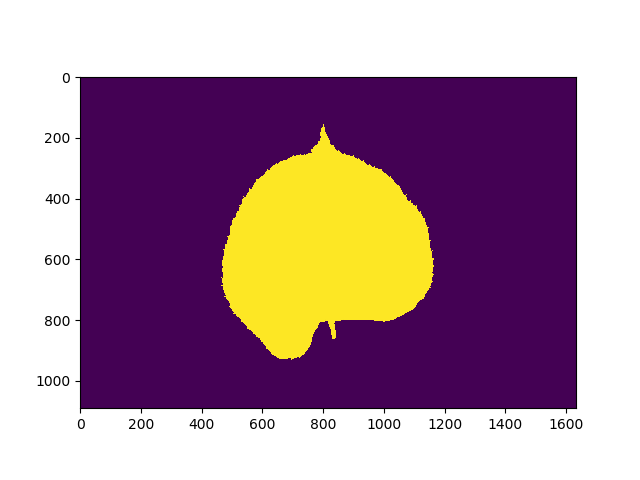

In [28]:
idd = 250
print(images_exp[idd].shape)
plt.figure()
plt.imshow(images_exp[idd][:,:,0])

In [34]:
model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=(1089, 1633,1),
               activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=99, activation='sigmoid'))

In [35]:
model = Model(in_layer, output_layer)
model.compile(optimizer = "adam", loss = "categorical_crossentropy",
            metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1089, 1633, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1086, 1630, 16)    272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1083, 1627, 32)    8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1083, 1627, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1080, 1624, 64)    32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1080, 1624, 64)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1080, 1624, 128)   8320      
__________

In [31]:
#in_layer = Input(shape=(1089, 1633,1))
#x = Conv2D(16,(4,4), activation = 'elu')(in_layer)  # single stride 4x4 filter for 16 maps
#x = Conv2D(32,(4,4), activation = 'elu')(x)         # single stride 4x4 filter for 32 maps
#x = Dropout(0.5)(x)
#x = Conv2D(64,(4,4), activation = 'elu')(x)         # single stride 4x4 filter for 64 maps
#x = Dropout(0.5)(x)
#x = Conv2D(128, (1,1))(x)                           # finally 128 maps for global average-pool
#x = GlobalMaxPooling2D()(x)                     # pseudo-dense 128 layer
#output_layer = Dense(99, activation = "softmax")(x) # softmax output
#
#model = Model(in_layer, output_layer)
#model.compile(optimizer = "adam", loss = "categorical_crossentropy",
#            metrics=["accuracy"])
#model.summary()

In [36]:
model.fit(images_exp, target_mc, batch_size = 1, epochs = 50, validation_split=0.2)

Train on 792 samples, validate on 198 samples
Epoch 1/50
792/792 [==============================] - 129s 163ms/step - loss: 15.9553 - acc: 0.0101 - val_loss: 15.9553 - val_acc: 0.0101
Epoch 2/50
432/792 [===============>..............] - ETA: 55s - loss: 16.0062 - acc: 0.0069

KeyboardInterrupt: 